# Linear Model Deviation-based Outlier Detection (LMDD-OD)

----

**Created by**:

- **Author**: Dr. Saad Laouadi
- **Date**: 18/08/2024

This notebook was created by dr. Saad Laouadi on August 11th, 2024 as part of a series on anomaly detection algorithms. The content is designed for researchers, data scientists, and practitioners interested in applying the PCA Outlier Detector algorithm to identify anomalies in a dataset.

**Copyright**

**© 2024 Dr. Saad Laouadi. All rights reserved.**

---

## Table of Contents

## Table of Contents
1. [Objective](#Objective)
2. [Prerequisites](#Prerequisites)
3. [Theoretical Background of k-Nearest Neighbors for Outlier Detection (kNN)](#Theoretical-Background-of-KNN-Outlier-Detector)
    - [1. Introduction](#1-Introduction)
    - [2. Core Components](#2.-Core-Components)
       - [2.1 K-Nearest Neighbors Algorithm](#2.1-K-Nearest-Neighbors-Algorithm)
       - [2.2 Distance Metrics](#2.2-Distance-Metrics)
       - [2.3 Anomaly Score Calculation](#2.3-Anomaly-Score-Calculation)
       - [2.4 Local Outlier Factor (LOF)](#2.4-Local-Outlier-Factor-(LOF))
4. [Theoretical Underpinnings](#3.-Theoretical-Underpinnings)
   - [4.1 Unsupervised Learning Theory](#3.1-Unsupervised-Learning-Theory)
   - [4.2 Proximity-Based Outlier Detection](#3.2-Proximity-Based-Outlier-Detection)
   - [4.3 Statistical Distance Theory](#3.3-Statistical-Distance-Theory)
5. [Mathematical Framework](#4.-Mathematical-Framework)
   - [5.1 K-Nearest Neighbors Model](#41-k-nearest-neighbors-model)
   - [5.2 Local Outlier Factor](#42-local-outlier-factor)
   - [5.3 Anomaly Classification](#43-anomaly-classification)
6. [Computational Complexity](#5.-Computational-Complexity)
7. [Using kNN for Outlier Detection Using PyOD Framework](#Using-k-Nearest-Neighbors-(kNN)-for-Outlier-Detection-Using-PyOD-Framework)
   - 7.1. [Key Parameters of kNN](#Key-Parameters-of-kNN)
   - 7.2. [Methods in kNN](#Methods-in-kNN)
   - 7.3. [Training Workflow for kNN](#Training-Workflow-for-kNN)
8. [Practical Example of kNN System with Simulated Data](#Practical-Example-of-k-Nearest-Neighbors-(kNN)-for-Outlier-Detection-with-Simulated-Data)
9. [Real-World Example](#Real-World-Example)
10. [Training kNN as an Unsupervised Problem](#Training-k-Nearest-Neighbors-(kNN)-for-Unsupervised-Outlier-Detection)
11. [Fine-Tune KNN Algorithm](#Fine-Tune-KNN-Algorithm)

---

## Objective

The primary objective of this notebook is to provide a comprehensive exploration of the **Principal Component Analysis (PCA) Outlier Detector** algorithm, encompassing its theoretical foundations, practical implementation, and performance evaluation. Specifically, this notebook aims to:

1. **Elucidate the Theoretical Framework**: Present a detailed explanation of the underlying principles of PCA and its application to outlier detection, including the concepts of principal components, variance explanation, and reconstruction error.

2. **Demonstrate Practical Implementation**: Guide readers through the step-by-step process of implementing PCA Outlier Detector using popular machine learning libraries, with a focus on code efficiency and best practices.

3. **Explore Hyperparameter Tuning**: Investigate the impact of various hyperparameters, particularly the number of principal components and the threshold for outlier detection, on the PCA Outlier Detector's performance, providing insights into optimal configuration for different types of datasets.

4. **Analyze Performance**: Evaluate PCA Outlier Detector's effectiveness in identifying outliers using both synthetic and real-world datasets, employing appropriate evaluation metrics and visualization techniques.

5. **Compare with Other Techniques**: Benchmark PCA Outlier Detector against other outlier detection methods to highlight its strengths and potential limitations, especially in handling high-dimensional data.

6. **Discuss Real-World Applications**: Present case studies demonstrating PCA Outlier Detector's applicability in various domains, such as image processing, financial anomaly detection, or identifying unusual patterns in scientific experiments.

7. **Address Challenges and Limitations**: Discuss potential challenges in implementing PCA Outlier Detector, including its sensitivity to scale, the assumption of linearity, and the interpretability of results in high-dimensional spaces.

8. **Explore Extensions and Variants**: Introduce readers to advanced topics related to PCA-based outlier detection, such as Kernel PCA for non-linear relationships and robust PCA for handling contaminated datasets.

By the end of this notebook, readers will have gained a thorough understanding of the PCA Outlier Detector, equipped with the knowledge and practical skills to apply this algorithm effectively in their own anomaly detection tasks across diverse datasets and domains, particularly those involving high-dimensional data.

### Prerequisites

This notebook assumes a foundational understanding of Python tools for data manipulation and processing. The following prerequisites will help you get the most out of this material:

1. **Data Manipulation**:
   - Familiarity with reading and writing data using libraries such as **Pandas** and **NumPy**.

2. **Machine Learning Workflow**:
   - Prior experience with the **Scikit-learn** library, including:
     - Preprocessing techniques like scaling and normalization.
     - Splitting data into training and test sets using tools like `train_test_split`.

3. **Data Visualization**:
   - Proficiency in using plotting libraries such as **Matplotlib** and **Seaborn** for visualizing data and model results.

In [1]:
# ============================================================================================# 
#                                 Environment Setup
#  Here we import all the necessary modules and tools we will use through this notebook
# ============================================================================================# 
import os
import sys
import time
from collections import Counter

import numpy as np 
import pandas as pd
from scipy.io import arff

from pyod.models.abod import ABOD
from pyod.models.ecod import ECOD
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.auto_encoder import AutoEncoder

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

# The utils module is not an installable package, it is the same directory as this notebook
from utils import generate_data, visualize_data, apply_abod, apply_abod_advanced, precision_at_rank_n
from utils import grid_search_abod, hyperopt_objective, plot_outliers_vs_inliers
from utils import preprocess_pipeline

from suod_utils import generate_sample_data, evaluate_model, visualize_results

from pyod.models.suod import SUOD
from pyod.models.lof import LOF
from pyod.models.iforest import IForest
from pyod.models.copod import COPOD
from pyod.models.knn import KNN
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.utils.utility import standardizer
from pyod.utils.data import generate_data, get_outliers_inliers, evaluate_print
from pyod.utils.example import visualize

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll.base import scope

def print_banner(sep, nchar, title):
    print(sep * nchar)
    print(title.center(nchar))
    print(sep * nchar)

# Configuration 
DATA_PATH = "../../datasets/HeartDisease/HeartDisease_withoutdupl_norm_44.arff"

# Theoretical Background of PCA Outlier Detector

## 1. Introduction

Principal Component Analysis Outlier Detector (PCA-OD) is an unsupervised machine learning algorithm designed for detecting anomalies or outliers in complex, high-dimensional datasets. It leverages the dimensionality reduction capabilities of PCA to identify data points that significantly deviate from the main patterns in the data.

PCA-OD operates on the assumption that normal data points lie close to the principal subspace defined by the top principal components, while anomalies are located far from this subspace. By examining the reconstruction error or the distance to the principal subspace, the algorithm can quantify how much a point differs from the main data distribution.

The fundamental premise underlying PCA-OD's effectiveness is rooted in the concept of variance explanation. While normal data points are well-represented by the top principal components, outliers often require additional components to be accurately reconstructed. This difference in representation forms the basis for anomaly identification.

By exploiting this principle, PCA-OD offers a powerful tool for detecting anomalies in high-dimensional spaces where traditional distance-based methods may falter. Its ability to capture global patterns in data makes it particularly suited for datasets with complex correlations across features, from image processing to financial fraud detection.

## 2. Core Components

### 2.1 Principal Component Analysis

The PCA-OD algorithm employs Principal Component Analysis, consisting of:
- Computation of the covariance matrix of the data
- Eigendecomposition of the covariance matrix to find principal components
- Projection of data onto the principal component space

### 2.2 Dimensionality Reduction

PCA performs dimensionality reduction by selecting the top k principal components that explain most of the variance in the data. This step is crucial for filtering out noise and focusing on the most important patterns.

### 2.3 Anomaly Score Calculation

The key idea in PCA-OD is to use the reconstruction error or the distance to the principal subspace as an anomaly score. Normal data points, which are well-represented by the top principal components, will have low anomaly scores. Conversely, anomalies or outliers, being poorly represented, will typically result in higher anomaly scores.

### 2.4 Variants of PCA-OD

Extensions of the basic PCA-OD include Kernel PCA for non-linear relationships and Robust PCA for handling datasets with a high proportion of outliers.

## 3. Theoretical Underpinnings

### 3.1 Unsupervised Learning Theory

PCA-OD operates within the framework of unsupervised learning, where the algorithm learns patterns and structures from data without explicit labels. The theory of unsupervised learning, particularly manifold learning and spectral methods, forms the basis for understanding how PCA-OD can identify anomalies without prior knowledge of what constitutes an anomaly.

### 3.2 Linear Algebra and Eigendecomposition

The concept of eigendecomposition is crucial to PCA-OD. It allows the algorithm to find the directions of maximum variance in the data, which form the basis for the principal subspace.

### 3.3 Information Theory

Information theory provides insights into the compression achieved by PCA. The principal components can be viewed as an efficient coding of the data, with anomalies requiring more information to encode accurately.

## 4. Mathematical Framework

### 4.1 PCA Model

Let X be the data matrix. The PCA transformation can be expressed as:

$$Z = X W$$

where W is the matrix of principal component loadings.

### 4.2 Reconstruction Error

The reconstruction error for a data point x can be calculated as:

$$e(x) = ||x - \hat{x}||^2$$

where $\hat{x} = W_k W_k^T x$ is the reconstruction of x using the top k principal components.

### 4.3 Anomaly Score

The anomaly score S for a data point x can be defined as:

$$S(x) = e(x) = ||x - W_k W_k^T x||^2$$

### 4.4 Anomaly Classification

A threshold τ is often used to classify points as anomalies:

If $S(x) > τ$, x is classified as an anomaly.

## 5. Computational Complexity

The computational complexity of PCA-OD can be divided into two phases:

1. PCA computation: $O(min(n^2p, np^2))$, where n is the number of data points and p is the number of features.

2. Scoring: $O(npk)$, where k is the number of principal components used.

The exact complexity can vary based on the specific implementation and the chosen number of principal components. While the algorithm can be computationally intensive for very high-dimensional datasets, various approximation techniques can be employed to improve performance, making PCA-OD suitable for many real-world anomaly detection applications.

## Linear Model Deviation-based Outlier Detection (LMDD)

The `LMDD` class from the `pyod.models.lmdd` module implements Linear Model Deviation-based Outlier Detection. LMDD leverages the concept of a smoothing factor, which quantifies how much dissimilarity can be reduced by removing a subset of elements from the dataset. This approach allows for effective identification of outliers by measuring the deviation of data points from the expected behavior.

### Key Parameters of LMDD

- **contamination**: The proportion of outliers in the dataset.
  - Type: `float` in (0., 0.5) (default=`0.1`)
  - Used when fitting to define the threshold on the decision function.

- **n_iter**: The number of iterations for the detection process.
  - Type: `int` (default=`50`)
  - Higher values improve accuracy but increase execution time.

- **dis_measure**: The dissimilarity measure used to calculate the smoothing factor.
  - Type: `str` (default=`'aad'`)
  - Options: 
    - `'aad'`: Average Absolute Deviation
    - `'var'`: Variance
    - `'iqr'`: Interquartile Range

- **random_state**: The seed for the random number generator.
  - Type: `int`, `RandomState` instance, or `None` (default=`None`)

### Methods in LMDD

- **fit()**: Fits the LMDD model to the training data.
  - **Parameters**:
    - `X`: The input data to train on (numpy array of shape `(n_samples, n_features)`).
  - **Returns**:
    - `self`: The fitted LMDD instance.
  - **Example**:
    ```python
    lmdd.fit(X_train)
    ```

- **predict()**: Predicts whether each sample is an outlier or not.
  - **Parameters**:
    - `X`: The input data to predict (numpy array of shape `(n_samples, n_features)`).
    - `return_confidence`: If `True`, also returns the confidence of the prediction.
  - **Returns**:
    - `outlier_labels`: Binary labels for each sample (0 for inliers, 1 for outliers).
    - `confidence` (optional): Confidence of the prediction (only returned if `return_confidence=True`).
  - **Example**:
    ```python
    y_pred = lmdd.predict(X_test)
    ```

- **decision_function()**: Computes the anomaly scores for the input data based on the fitted LMDD model.
  - **Parameters**:
    - `X`: The input data to score (numpy array of shape `(n_samples, n_features)`).
  - **Returns**:
    - `anomaly_scores`: The anomaly scores for each sample (numpy array of shape `(n_samples,)`). Higher scores indicate a higher likelihood of being an outlier.
  - **Example**:
    ```python
    outlier_scores = lmdd.decision_function(X_test)
    ```

- **fit_predict()**: Fits the detector and then predicts whether each sample is an outlier.
  - **Parameters**:
    - `X`: The input data to fit and predict on (numpy array of shape `(n_samples, n_features)`).
  - **Returns**:
    - `outlier_labels`: Binary labels for each sample (0 for inliers, 1 for outliers).
  - **Example**:
    ```python
    y_pred = lmdd.fit_predict(X_test)
    ```

- **fit_predict_score()**: Fits the detector, predicts on samples, and evaluates the model by predefined metrics.
  - **Parameters**:
    - `X`: The input data to fit and predict on (numpy array of shape `(n_samples, n_features)`).
    - `scoring`: The evaluation metric (default=`'roc_auc_score'`).
  - **Returns**:
    - `score`: The evaluation score (float).
  - **Example**:
    ```python
    score = lmdd.fit_predict_score(X_test, scoring='roc_auc_score')
    ```

- **get_params()**: Retrieves the parameters for this estimator.
  - **Parameters**:
    - `deep`: If `True`, returns the parameters for the estimator and contained subobjects that are estimators (optional, default=`True`).
  - **Returns**:
    - `params`: A mapping of parameter names to their values.

- **set_params()**: Sets the parameters of this estimator.
  - **Parameters**:
    - `params`: A mapping of parameter names to their values.
  - **Returns**:
    - `self`: The estimator instance with updated parameters.

### Attributes of LMDD

- **decision_scores_**: The outlier scores of the training data. Higher scores indicate higher likelihoods of being outliers.
  - Type: `numpy array` of shape `(n_samples,)`

- **threshold_**: The threshold based on contamination, used for generating binary outlier labels.
  - Type: `float`

- **labels_**: The binary labels of the training data, where `0` stands for inliers and `1` for outliers/anomalies.
  - Type: `int`

### Example Usage

Here is an example of how to use the `LMDD` model for outlier detection:

```python
from pyod.models.lmdd import LMDD

# Initialize the LMDD model
lmdd = LMDD(contamination=0.1, n_iter=50, dis_measure='aad')

# Fit the model to the training data
lmdd.fit(X_train)

# Predict the outliers in the test data
y_pred = lmdd.predict(X_test)

# Calculate anomaly scores
outlier_scores = lmdd.decision_function(X_test)
```

---

## Practical Example of k-Nearest Neighbors (kNN) for Outlier Detection with Simulated Data

In this section, we demonstrate the application of the k-Nearest Neighbors (kNN) algorithm for outlier detection using simulated data. We will walk through the process of:
1. Generating sample datasets
2. Initializing the kNN model for outlier detection
3. Training the kNN model to identify outliers based on distance to neighbors
4. Evaluating the system's performance in identifying anomalies
5. Visualizing the results to gain insights into the detected outliers

This example will provide a hands-on understanding of how kNN can be effectively utilized in practice for outlier detection.

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
  radius=1.0)
y_train has multiple classes: {np.float64(0.0), np.float64(1.0)}
y_test has multiple classes: {np.float64(0.0), np.float64(1.0)}

On Training Data:
kNN ROC:0.985, precision @ rank n:0.9444

On Test Data:
kNN ROC:1.0, precision @ rank n:1.0


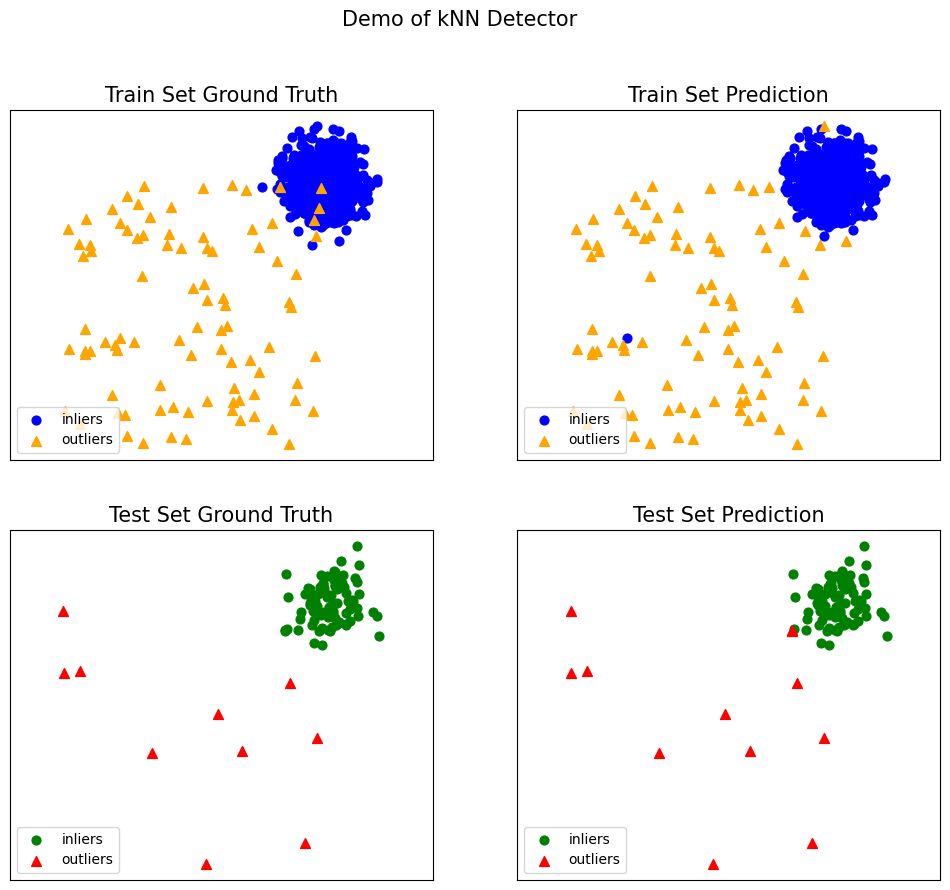

Process took 0.7356219291687012 seconds.


In [2]:
# Configuration
PRINT_MODEL_INFO = True                              # Set this to True to print the kNN model details

start = time.time()
if __name__ == "__main__":
    contamination = 0.1                              # Percentage of outliers
    n_train = 900                                    # Number of training points
    n_test = 100                                     # Number of testing points

    # Generate synthetic data
    X_train, X_test, y_train, y_test = generate_sample_data(
        n_train=n_train, n_test=n_test, n_features=2, contamination=contamination, random_state=42
    )

    # Initialize the kNN detector
    knn = KNN(
        contamination=contamination,
        n_neighbors=5,
        method='largest',                     # Use the distance to the kth neighbor as the outlier score
        radius=1.0,
        algorithm='auto',
        leaf_size=30,
        metric='minkowski',
        p=2,
        n_jobs=-1,                              # Use all available cores
    )

    # Train the kNN model
    knn.fit(X_train)
    
    if PRINT_MODEL_INFO:
        print(knn)                                # Print the kNN model details
         
    # Get predictions
    y_train_pred = knn.predict(X_train)
    y_test_pred = knn.predict(X_test)
    
    # Get outlier scores
    y_train_scores = knn.decision_function(X_train)
    y_test_scores = knn.decision_function(X_test)

    # Evaluate the model
    evaluate_model('kNN', y_train, y_train_scores, y_test, y_test_scores)

    # Visualize the results
    visualize_results('kNN', X_train, y_train, X_test, y_test, y_train_pred, y_test_pred)

end = time.time()

print(f"Process took {end - start} seconds.")

## Real-World Example

We will use the heart disease dataset, the same dataset used in the previous algorithm examples. For more details on the dataset, you can refer to the [ABOD algorithm notebook](03-abod-algorithm.ipynb) or visit [this link](https://www.dbs.ifi.lmu.de/research/outlier-evaluation/DAMI/semantic/HeartDisease/HeartDisease_44.html).

### k-Nearest Neighbors Outlier Detection (kNN) Workflow

To effectively leverage the k-Nearest Neighbors (kNN) algorithm for outlier detection, follow these comprehensive steps:

1. **Data Preprocessing**:
   - **Handle Missing Data**: Impute or remove missing values to ensure the dataset's integrity.
   - **Eliminate Duplicates**: Remove duplicate entries to prevent bias in the outlier detection process.
   - **Encode Categorical Features**: Convert categorical variables into numerical format using techniques such as one-hot encoding or label encoding.
   - **Scale Features**: Normalize or standardize features to ensure a uniform scale across all input variables, which is crucial for many machine learning algorithms.
   - **Dimensionality Reduction** (Optional): Use techniques like PCA to reduce dimensionality, particularly when dealing with high-dimensional data.

2. **Applying the kNN Detector**:
   - **Initialize the kNN Model**: Set up the kNN detector, specifying parameters such as the number of neighbors, method, and metric.
   - **Train the Model**: Fit the kNN model to the preprocessed data. The model will assess the distance to the kth nearest neighbor to identify outliers.
   - **Prediction**: Use the trained kNN model to predict outliers in the dataset by evaluating the distance to the nearest neighbors.

3. **Performance Evaluation**:
   - **Compute Metrics**: Evaluate the performance of the kNN model using metrics such as:
     - Precision
     - ROC AUC (Area Under the Receiver Operating Characteristic Curve)
     - Average Precision
   - **Cross-Validation**: Implement k-fold cross-validation to ensure robust performance assessment.

4. **Result Analysis and Interpretation**:
   - **Visualize Outliers**: Generate scatter plots or other visualizations to represent detected outliers visually.
   - **Analyze Outlier Characteristics**: Identify common features or patterns among the detected outliers.
   - **Domain-Specific Interpretation**: Contextualize the detected outliers within the specific domain of the dataset.
   - **Comparative Analysis**: Compare the kNN model's results with traditional single-algorithm approaches if applicable.

5. **Model Refinement** (Optional):
   - **Hyperparameter Tuning**: Adjust the kNN model's parameters based on the initial results to improve performance.
   - **Method Adjustment**: Modify the kNN method (e.g., using the median or mean of neighbors' distances) to enhance its ability to detect outliers.

> **Note**:  
> To reproduce the results in the following example, ensure you have downloaded the required dataset and saved it in an accessible directory. Additionally, verify that all necessary libraries and dependencies are installed in your environment.

### Configuring the k-Nearest Neighbors Detector

In this example, I will configure the kNN model with the following parameters to detect outliers:

- **Number of Neighbors**: 
  - `n_neighbors=5`
- **Method**: 
  - `'largest'` to use the distance to the kth neighbor as the outlier score.
- **Metric**: 
  - `'minkowski'` with `p=2` (equivalent to Euclidean distance).
- **Algorithm**: 
  - `'auto'` to automatically determine the best algorithm for computing the nearest neighbors.
- **Leaf Size**: 
  - `30` to control the speed of the construction and query process.

In [3]:
PRINT_MODEL_INFO = False 

# Function to load the dataset
def load_arff_data(filepath):
    """
    Load an ARFF file and return it as a pandas DataFrame.

    Parameters
    ----------
    filepath : str
        Path to the ARFF file.

    Returns
    -------
    data : DataFrame
        The loaded dataset.
    """
    data, meta = arff.loadarff(filepath)
    df = pd.DataFrame(data)
    
    # Convert byte strings to normal strings for categorical variables
    for column in df.select_dtypes([object]).columns:
        df[column] = df[column].str.decode('utf-8')
    
    return df

# Preprocess the dataset
def preprocess_heart_disease_data(df, target_name, scale=False):
    """
    Preprocess the Heart Disease dataset.

    Parameters
    ----------
    df : DataFrame
        The loaded dataset.
    target_name: str
        The target column name.

    Returns
    -------
    X : ndarray
        Feature matrix.
    y : ndarray
        Target vector (outlier labels).
    """
    X = df.drop(columns=[target_name])                                 
    y = df[target_name].apply(lambda x: 1 if x == 'yes' else 0).values

    if scale:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = X
    
    return X_scaled, y

def stratify_split_data(X, y, test_size=0.1, random_state=42):
    """
    Split the data into training and testing sets with stratification.

    Parameters
    ----------
    X : ndarray
        Feature matrix.
    y : ndarray
        Target vector.
    test_size : float, optional
        Proportion of the dataset to include in the test split (default is 0.1).
    random_state : int, optional
        Seed for random number generation (default is 42).

    Returns
    -------
    X_train : ndarray
        Training feature matrix.
    X_test : ndarray
        Testing feature matrix.
    y_train : ndarray
        Training target vector.
    y_test : ndarray
        Testing target vector.
    """
    # Ensure that the test set has a similar distribution of classes as the full dataset
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y, 
                                                        test_size=test_size,
                                                        random_state=random_state,
                                                        stratify=y)
    
    # Check class distribution
    print(f"Training set class distribution: {Counter(y_train)}")
    print(f"Test set class distribution: {Counter(y_test)}")
    
    return X_train, X_test, y_train, y_test

# Example of using the above functions with kNN
if __name__ == "__main__":
    # Load the dataset
    DATA_PATH = "../../datasets/HeartDisease/HeartDisease_withoutdupl_norm_44.arff"
    df = load_arff_data(DATA_PATH)

    # Preprocess the dataset
    X, y = preprocess_heart_disease_data(df, target_name='outlier', scale=True)

    # Optionally split the dataset if needed (although for unsupervised learning, this may not be required)
    X_train, X_test, y_train, y_test = stratify_split_data(X, y, test_size=0.1, random_state=42)

    # Initialize the kNN detector
    knn = KNN(
        contamination=0.4444,                
        n_neighbors=5,   
        method='largest',                     
        metric='minkowski',                    
        n_jobs=-1,
        radius=1.0,
        leaf_size=30
    )

    # Train the kNN model
    knn.fit(X_train)

    if PRINT_MODEL_INFO:
        print(knn)  # Print the kNN model summary (though kNN does not have a model summary like neural networks)

    # Get predictions
    y_train_pred = knn.predict(X_train)
    y_test_pred = knn.predict(X_test)
    
    # Get outlier scores
    y_train_scores = knn.decision_function(X_train)
    y_test_scores = knn.decision_function(X_test)

    # Evaluate the model
    evaluate_model('kNN', y_train_pred, y_train_scores, y_test_pred, y_test_scores)

    # Print the indices of the detected outliers
    outlier_indices = np.where(y_test_pred == 1)[0]
    print("Indices of the outliers:")
    print(outlier_indices)

    # Slice the data to have only the outliers
    outliers_only = X_test[outlier_indices, :]
    print(f"Number of detected outliers: {outliers_only.shape[0]}")

Training set class distribution: Counter({np.int64(0): 135, np.int64(1): 108})
Test set class distribution: Counter({np.int64(0): 15, np.int64(1): 12})
y_train has multiple classes: {np.int64(0), np.int64(1)}
y_test has multiple classes: {np.int64(0), np.int64(1)}

On Training Data:
kNN ROC:1.0, precision @ rank n:1.0

On Test Data:
kNN ROC:1.0, precision @ rank n:1.0
Indices of the outliers:
[ 0  2  3  7  8 10 11 12 13 15 17 18 20 21 22 25]
Number of detected outliers: 16


## Training k-Nearest Neighbors (kNN) for Unsupervised Outlier Detection

In this section, we’ll demonstrate how to train the k-Nearest Neighbors (kNN) model for unsupervised outlier detection. kNN is particularly effective in scenarios where the goal is to identify anomalies or outliers in the dataset without any labeled data. The model measures the distance between data points and their neighbors, making it a reliable method for detecting outliers based on the density of data points in the feature space.

### Workflow Overview

1. **Data Preparation**:
    - We start by loading and preprocessing the dataset. Since the task is unsupervised, labels are not required for the training data.
    - The entire dataset will be used to train the kNN model, allowing it to learn the underlying distribution and density of the data points.

2. **Model Initialization**:
    - We initialize the kNN model with specified parameters such as the number of neighbors (`n_neighbors`), the method for calculating outlier scores (`method`), and the distance metric (`metric`).
    - These parameters can be adjusted to optimize the model's performance in detecting outliers, particularly in datasets with varying densities.

3. **Training the kNN Model**:
    - The kNN model is trained on the entire dataset. During training, the model calculates the distance between each data point and its k-nearest neighbors.
    - Data points that have significantly larger distances to their neighbors compared to others are flagged as potential outliers.

4. **Outlier Detection**:
    - After training, the model predicts which instances in the dataset are outliers based on the calculated distances to their nearest neighbors.
    - The identified outliers can be further analyzed to understand why they are considered anomalies.

5. **Results Analysis**:
    - We will analyze the detected outliers by reviewing their characteristics and how they differ from the inliers.
    - Visualization techniques will be employed to illustrate the separation between inliers and outliers, providing insights into the model’s effectiveness.

(270, 14)
(270,)
outlier
no     150
yes    120
Name: count, dtype: int64
120
************************************************************************
                        Training and Prediction                         
************************************************************************
************************************************************************
                         Displaying Information                         
************************************************************************
Outliers detected: 120 out of 270
Indices of the outliers:
[  0   1   4   9  12  13  14  15  23  26  29  32  35  37  44  45  46  47
  48  49  50  51  52  53  54  56  57  59  60  62  63  64  65  67  70  73
  75  76  78  79  80  82  85  87  98 100 101 103 105 108 110 113 116 117
 119 120 122 123 130 131 132 133 134 135 136 137 138 140 143 146 147 148
 156 158 159 160 161 162 163 164 166 169 171 172 173 176 180 181 183 185
 188 190 191 193 194 196 197 205 206 208 213 223 224 226 228 

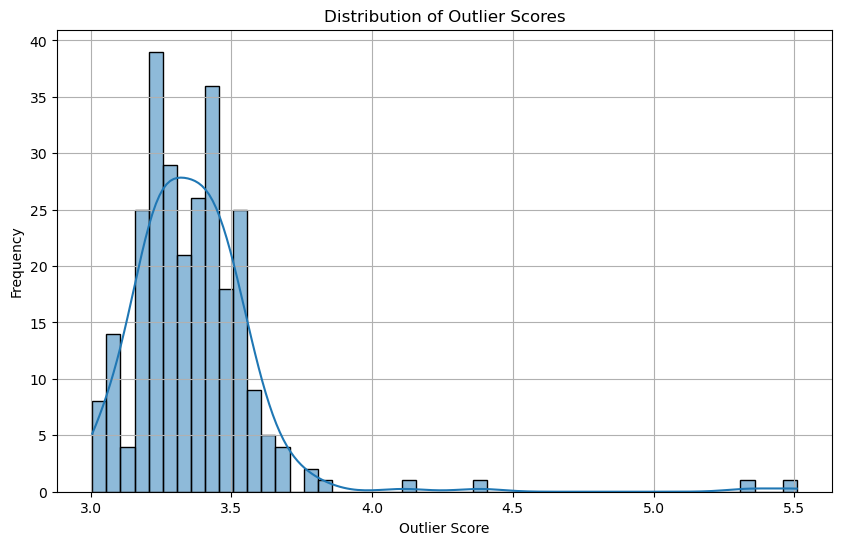

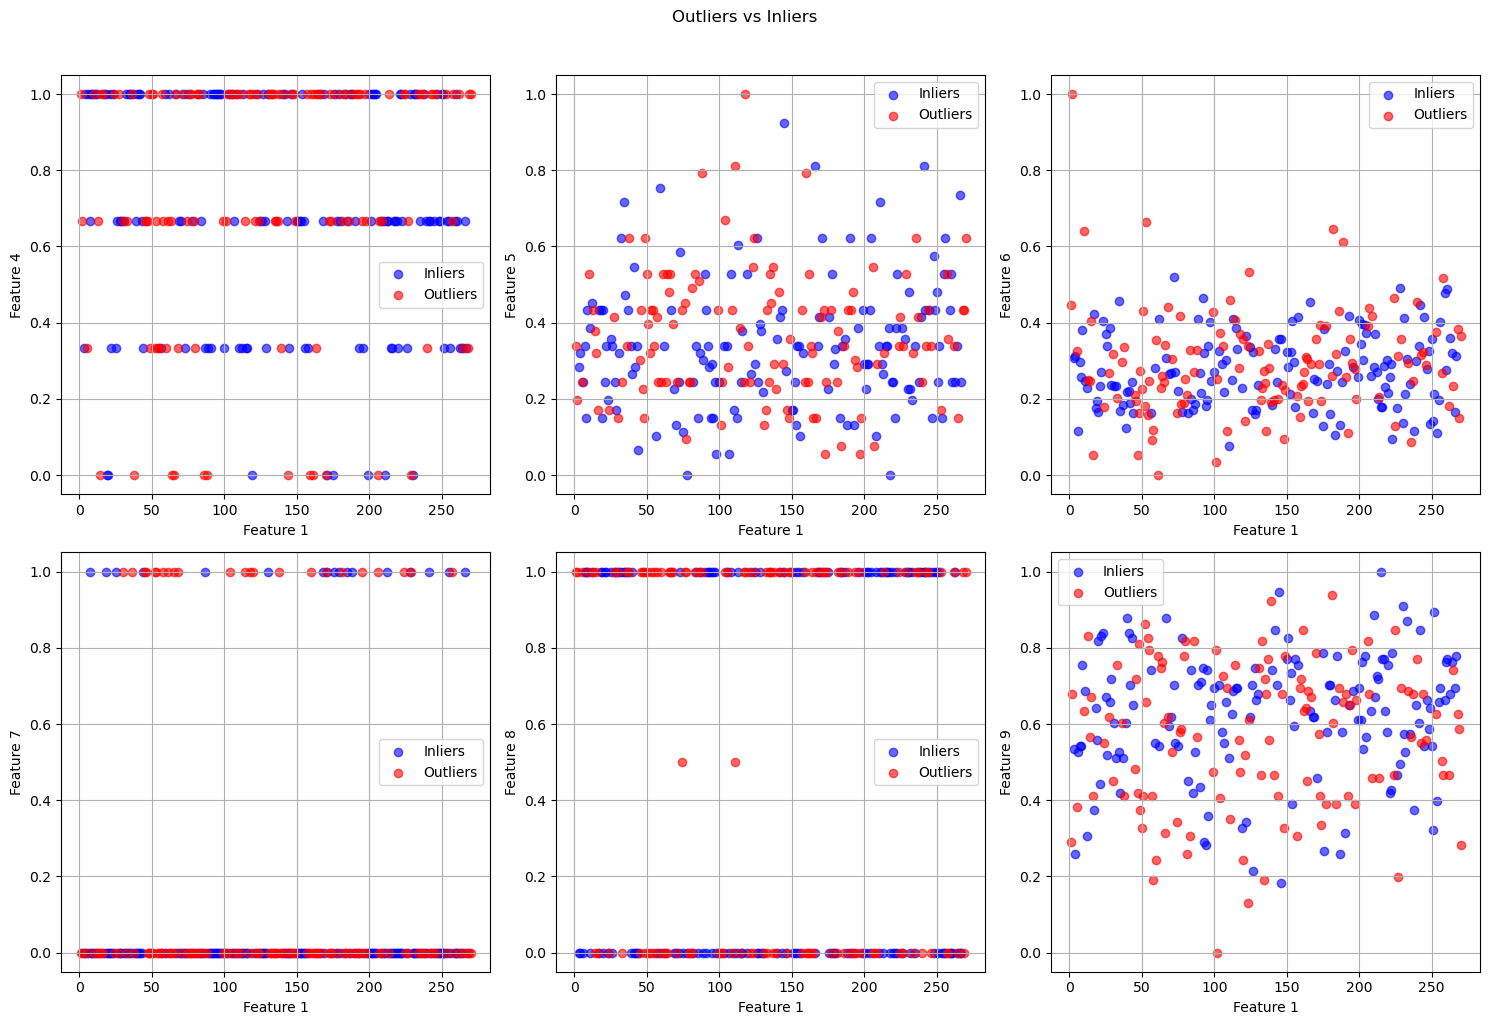

In [4]:
# Load and preprocess the dataset
df = load_arff_data(DATA_PATH)
X, y = preprocess_heart_disease_data(df, 'outlier')
print(X.shape)
print(y.shape)
print(df['outlier'].value_counts())
print(sum(y == 1))

# Initialize the kNN model
knn = KNN(
    contamination=0.4444, 
    n_neighbors=5, 
    method='largest', 
    metric='minkowski', 
    p=2
)

# Train the kNN model
knn.fit(X)

print_banner("*", 72, "Training and Prediction")

# Get predictions
y_pred = knn.labels_  # binary labels (0: inliers, 1: outliers)
outlier_scores = knn.decision_scores_  # raw outlier scores

print_banner("*", 72, "Displaying Information")
# You can now analyze the results
print(f"Outliers detected: {sum(y_pred)} out of {len(y_pred)}")

# Getting the outlier indexes
outlier_indices = np.where(y_pred == 1)[0]

# Print the indexes of the outliers
print("Indices of the outliers:")
print(outlier_indices)

# Slice the data to have only the outliers
outliers_only = X.iloc[outlier_indices, :]
print(outliers_only.shape[0])

print_banner("*", 72, "Plotting")

# Plot the distribution of outlier scores
plt.figure(figsize=(10, 6))
sns.histplot(outlier_scores, bins=50, kde=True)
plt.title("Distribution of Outlier Scores")
plt.xlabel("Outlier Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Plot outlier scores against selected features
plot_outliers_vs_inliers(X, y_pred=y_pred, plot_features=[3, *range(4, 9)])

---

### Fine-Tune KNN Algorithm

In this section we will try to find the best hyperparameter `n-neighbors`, since we have prior information about the number of outliers. The best `n-neighbors` is determined based on the `precision at rank n` metric. 

We will be using the `hyperopt` package to find the best hyperparameters.  I assume you already have a background about hyperparameter tuning techniques, because they are beyond the scope of this notebook tutorial. 

In [5]:
from utils import precision_n_scores
# Fine the KNN algorithm using hyperopt framework
# ===============================================

# Known contamination rate
contamination = 0.4444

# Known number of outliers
n_outliers = int(contamination * len(y))

# The search space for n_neighbors
search_space = {
    'n_neighbors': scope.int(hp.quniform('n_neighbors', 2, 50, 1))
}

def hyperopt_objective(params, X, y, n_outliers, contamination):
    """
    Objective function for Hyperopt to optimize the n_neighbors parameter of ABOD.

    Parameters
    ----------
    params : dict
        Dictionary containing the hyperparameter 'n_neighbors'.

    X_scaled : ndarray
        The scaled feature matrix.

    y : ndarray
        The true labels.

    n_outliers : int
        The number of true outliers.

    contamination : float
        The contamination rate (proportion of outliers).

    Returns
    -------
    dict
        Dictionary containing the loss (negative precision at rank n) and the status.
    """
    n_neighbors = params['n_neighbors']

    knn = KNN(n_neighbors=n_neighbors, contamination=contamination)

    # Fit the model to the data
    knn.fit(X)

    # Predict the outlier scores
    outlier_scores = knn.decision_scores_

    # Calculate precision at rank n
    precision_n = precision_n_scores(y, outlier_scores, n=n_outliers)

    return {'loss': -precision_n, 'status': STATUS_OK}


# Use Hyperopt to optimize the n_neighbors parameter
trials = Trials()
best = fmin(fn=lambda params: hyperopt_objective(params, X_train, y_train, n_outliers, contamination),
            space=search_space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print(f"Best n_neighbors: {best['n_neighbors']}")

100%|██████████| 100/100 [00:00<00:00, 368.28trial/s, best loss: -0.6050420168067226]
Best n_neighbors: 32.0


We will rerun the supervised example using this hyperparameter:

In [6]:
# Example of using the above functions with kNN with best n_neighbors hyperparameter:
if __name__ == "__main__":
    DATA_PATH = "../../datasets/HeartDisease/HeartDisease_withoutdupl_norm_44.arff"
    df = load_arff_data(DATA_PATH)
    X, y = preprocess_heart_disease_data(df, target_name='outlier', scale=True)
    X_train, X_test, y_train, y_test = stratify_split_data(X, y, test_size=0.1, random_state=42)

    knn = KNN(
        contamination=0.4444,                
        n_neighbors=41,   
        method='largest',                     
        metric='minkowski',                    
        n_jobs=-1,
        radius=1.0,
        leaf_size=30
    )

    knn.fit(X_train)
    y_train_pred = knn.predict(X_train)
    y_test_pred = knn.predict(X_test)
    
    # Get outlier scores
    y_train_scores = knn.decision_function(X_train)
    y_test_scores = knn.decision_function(X_test)

    # Evaluate the model
    evaluate_model('kNN', y_train_pred, y_train_scores, y_test_pred, y_test_scores)

    # Print the indices of the detected outliers
    outlier_indices = np.where(y_test_pred == 1)[0]
    print("Indices of the outliers:")
    print(outlier_indices)

    # Slice the data to have only the outliers
    outliers_only = X_test[outlier_indices, :]
    print(f"Number of detected outliers: {outliers_only.shape[0]}")

Training set class distribution: Counter({np.int64(0): 135, np.int64(1): 108})
Test set class distribution: Counter({np.int64(0): 15, np.int64(1): 12})
y_train has multiple classes: {np.int64(0), np.int64(1)}
y_test has multiple classes: {np.int64(0), np.int64(1)}

On Training Data:
kNN ROC:1.0, precision @ rank n:1.0

On Test Data:
kNN ROC:1.0, precision @ rank n:1.0
Indices of the outliers:
[ 0  2  7  8 10 11 12 13 15 18 20 21 22 24 25]
Number of detected outliers: 15


## KNN in Practice

In this section, we will demonstrate the application of the ABOD algorithm on various benchmark datasets across different domains:

1.	**Computer Vision Dataset**: The well-known MNIST dataset.
2.	**Text Analysis Dataset**:   Amazon Reviews dataset.
3.	**Network Intrusion Detection Dataset**: An intrusions simulated dataset in a military network environment. 

**To do** 

`...` This section will be written later `...`

In [7]:
mnist_path = "../../datasets/Classical/24_mnist.npz"
mnist = np.load(mnist_path, allow_pickle=True)
X, y = mnist['X'], mnist['y']

print(X.shape)
print(y.shape)
print(np.count_nonzero(y)/len(y))

(7603, 100)
(7603,)
0.09206892016309351


In [8]:
amazon_path = "../../datasets/NLP_by_BERT/amazon.npz"
amazon = np.load(amazon_path, allow_pickle=True)
X, y = amazon['X'], amazon['y']

print(X.shape)
print(y.shape)
print(np.count_nonzero(y)/len(y))

(10000, 768)
(10000,)
0.05


In [9]:
## Load Intrusion datasets
train = pd.read_csv("../../datasets/networkIntrosion/Train_data.csv")
test = pd.read_csv("../../datasets/networkIntrosion/Test_data.csv")

print(train.shape)
# print(train.info())

(25192, 42)


In [10]:
print(test.shape)
# print(test.info())

(22544, 41)


In [11]:
# Check the `class` which is the target
print(train.loc[:, "class"].value_counts())

class
normal     13449
anomaly    11743
Name: count, dtype: int64


In [12]:
# Identify categorical and numerical columns
categorical_cols = [col for col in train.columns.to_list() if train[col].dtype=='object' and col !='class']
numerical_cols = [col for col in train.columns if col not in categorical_cols and col !='class']

# Prepare the data
X_train = train.drop(columns=['class']) 
y_train = train['class'].apply(lambda x: 1 if x == 'anomaly' else 0) 

# The X_test
X_test = test

In [13]:
# Apply preprocessing


In [14]:
# Apply KNN

In [15]:
# Visualize the results


## Conclusion

This notebook demonstrates the application of the **K-Nearest Neighbors Outlier Detector (ABOD)** algorithm across multiple contexts. Through theoretical exploration and practical implementation, we have showcased KNN's strengths in detecting anomalies in both artificial and real-world datasets.